# Цель лабораторной работы
Изучение сложных способов подготовки выборки и подбора гиперпараметров на примере метода ближайших соседей.

# Задание:


1. Выбрать набор данных (датасет) для решения задачи классификации или регрессии.
2. С использованием метода train_test_split разделить выборку на обучающую и тестовую.
3. Обучить модель ближайших соседей для произвольно заданного гиперпараметра K. Оценить качество модели с помощью подходящих для задачи метрик.
4. Построить модель и оценить качество модели с использованием кросс-валидации.
5. Произвести подбор гиперпараметра K с использованием GridSearchCV и кросс-валидации.


# 1. Импорт библиотек и данных

In [11]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/red-wine-quality-cortez-et-al-2009/winequality-red.csv


In [12]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline 
sns.set(style="ticks")

In [13]:
# Импорт датасета
wines = pd.read_csv('/kaggle/input/red-wine-quality-cortez-et-al-2009/winequality-red.csv', sep=",")

# 2. Характеристики  и описание датасета

В работе использован датасет *Red wine quality*, который содержит химические характеристики разновидностей португальского вина "Vinho Verde", а также рейтинг вина по совокупности его характеристик.

**В датасете представлены следующие признаки:**

1. *fixed acidity* - винная кислота, наиболее сильная и самая объёмная, присутствующая в виноградных винах, в значительной степени влияет на эффективную кислотность (pH) этих вин.
2. *volatile acidity* - количество уксусной кислоты в вине, при больших содержаниях может привести к неприятному уксусному вкусу.
3. *citric acid* - лимонная кислота в небольшом количестве может добавить свежести и аромату вину.
4. *residual sugar* - количество сахара, которое остается после окончания брожения, большинство вин содержат хотя бы 1 гр/л, а вина с содержанием сахара больше 45 гр/л считаются сладкими.
5. *chlorides* - количество солей в вине
6. *free sulfur dioxide* - свободная форма SO2, существующая в равновесном состоянии между молекулярным SO2 (как растворенный газ) и бисульфит-ионом; она предотвращает развитие микробов и окисление вина
7. *total sulfur dioxide* - количество свободного и связанного S02; в низких концентрациях, почти незаметен в вине, но при концентрации сбодной формы больше 50 ppm, может отразиться на вкусе вина

8. *density* - плотность воды, зависящая от процента алкогоголя и сахара

9. *pH* - водородный показатель, мера силы и концентрации диссоциированных кислот в растворе. Показатель варьируется от 0 (очень кислотный) до 14 (очень щелочной); большинство вин находятся в диапозоне 3-4 по pH шкале

10. *sulphates* - винная добавка,может повлиять на уровни диоксида сера (SO2), который выступает в роле антиоксиданта

11. *alcohol* - объёма растворённого безводного спирта к объёму всего вина в процентах

12. *quality* - оценка качества вина, рейтинг в диапозоне от 0 до 10.

In [14]:
# Первые 5 строк датасета
wines.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


In [15]:
# Статистические характеристики признаков
wines.describe()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
count,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000
mean,8.319637,0.527821,0.270976,2.538806,0.087467,15.874922,46.467792,0.996747,3.311113,0.658149,10.422983,5.636023
std,1.741096,0.179060,0.194801,1.409928,0.047065,10.460157,32.895324,0.001887,0.154386,0.169507,1.065668,0.807569
min,4.600000,0.120000,0.000000,0.900000,0.012000,1.000000,6.000000,0.990070,2.740000,0.330000,8.400000,3.000000
25%,7.100000,0.390000,0.090000,1.900000,0.070000,7.000000,22.000000,0.995600,3.210000,0.550000,9.500000,5.000000
50%,7.900000,0.520000,0.260000,2.200000,0.079000,14.000000,38.000000,0.996750,3.310000,0.620000,10.200000,6.000000
75%,9.200000,0.640000,0.420000,2.600000,0.090000,21.000000,62.000000,0.997835,3.400000,0.730000,11.100000,6.000000
max,15.900000,1.580000,1.000000,15.500000,0.611000,72.000000,289.000000,1.003690,4.010000,2.000000,14.900000,8.000000


# 3. Решение задачи регрессии
Для задачи регрессии был выбран целевой признак *total sulfur dioxide*, который является количественным и обладает большой дисперсией.

In [16]:
# Статистические характеристики целевого признака
wines['total sulfur dioxide'].describe()

count    1599.000000
mean       46.467792
std        32.895324
min         6.000000
25%        22.000000
50%        38.000000
75%        62.000000
max       289.000000
Name: total sulfur dioxide, dtype: float64

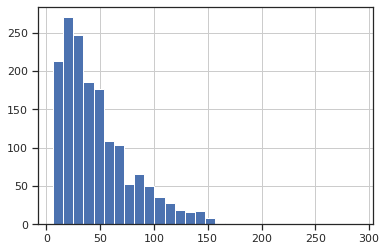

In [17]:
# Гистограмма целевого признака
wines['total sulfur dioxide'].hist(bins=30)

# 3.1 Разделение переменных и выборки

In [18]:
# Выделяем входные признаки
wines_regr_X = wines.drop('total sulfur dioxide', axis=1).values
wines_regr_X

array([[ 7.4  ,  0.7  ,  0.   , ...,  0.56 ,  9.4  ,  5.   ],
       [ 7.8  ,  0.88 ,  0.   , ...,  0.68 ,  9.8  ,  5.   ],
       [ 7.8  ,  0.76 ,  0.04 , ...,  0.65 ,  9.8  ,  5.   ],
       ...,
       [ 6.3  ,  0.51 ,  0.13 , ...,  0.75 , 11.   ,  6.   ],
       [ 5.9  ,  0.645,  0.12 , ...,  0.71 , 10.2  ,  5.   ],
       [ 6.   ,  0.31 ,  0.47 , ...,  0.66 , 11.   ,  6.   ]])

In [19]:
# Выделяем целевой признак
wines_regr_Y = wines['total sulfur dioxide']
wines_regr_Y

0       34.0
1       67.0
2       54.0
3       60.0
4       34.0
        ... 
1594    44.0
1595    51.0
1596    40.0
1597    44.0
1598    42.0
Name: total sulfur dioxide, Length: 1599, dtype: float64

In [20]:
# Разделение выборки на обучающую и тестовую
from sklearn.model_selection import train_test_split
wines_X_train, wines_X_test, wines_y_train, wines_y_test = train_test_split(
    wines_regr_X, wines_regr_Y, test_size=0.3, random_state=42)

# 3.2 Обучение модели и оценка качества

In [21]:
# Импорт метрик и knn моделей
from sklearn.neighbors import KNeighborsRegressor, KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_squared_log_error, median_absolute_error, r2_score 

In [22]:
# Строим модель 5 ближайших соседей
knn_5 = KNeighborsRegressor(n_neighbors=5)
knn_5.fit(wines_X_train, wines_y_train)
target_train = knn_5.predict(wines_X_train)
target_test = knn_5.predict(wines_X_test)

In [23]:
# Средняя квадратичная ошибка для обучающей и тестовой выборок
mean_squared_error(wines_y_train, target_train), mean_squared_error(wines_y_test, target_test)

(323.7699106344951, 546.4993125)

In [24]:
# Коэффициент детерминации для обучающей и тестовой выборок
r2_score(wines_y_train, target_train), r2_score(wines_y_test, target_test)

(0.703085341805602, 0.48368524104442)

Как видно из оценки качества, наблюдается явное **переобучение**: модель достаточно хорошо работает на обучающей выборке, но на тестовой показатель заметно ниже.

In [25]:
# Словарь метрик качества регрессии 
scoring = {'mae': 'neg_mean_absolute_error', 
           'mse': 'neg_mean_squared_error',
           'r2': 'r2'}

# 3.3 Построение модели и кросс-валидация

In [26]:
# Импортируем метод для осуществления кросс-валидации
from sklearn.model_selection import cross_validate

In [27]:
# Проводим кросс-валидацию для 5nn
scores = cross_validate(KNeighborsRegressor(n_neighbors=5), 
                        wines_regr_X, wines_regr_Y, scoring=scoring, 
                        cv=6, return_train_score=True)
scores

{'fit_time': array([0.00233817, 0.00186515, 0.00180483, 0.00186968, 0.0015583 ,
        0.00167966]),
 'score_time': array([0.00413656, 0.00344205, 0.00355577, 0.00370526, 0.00334764,
        0.00328684]),
 'test_mae': array([-22.20749064, -15.0082397 , -17.54382022, -14.83609023,
        -15.42631579, -16.3037594 ]),
 'train_mae': array([-10.97927928, -12.3253003 , -11.98160661, -12.70877719,
        -12.29677419, -12.02685671]),
 'test_mse': array([-935.36404494, -469.4906367 , -633.51745318, -425.56774436,
        -672.74834586, -541.17345865]),
 'train_mse': array([-280.01510511, -327.77313063, -313.87388138, -348.64168042,
        -303.49677419, -326.91687922]),
 'test_r2': array([0.30321343, 0.47160865, 0.47898158, 0.36615809, 0.45016106,
        0.40223157]),
 'train_r2': array([0.71919725, 0.70727975, 0.7018721 , 0.69457953, 0.71177172,
        0.70670668])}

Как видим из результатов кросс-валидации, коэффициент детерминации **существенно выше на обучающей выборке**, чем на тестовой. Проверим, возможно ли улучшить показатели, проведя подбор гиперпараметров.

# 3.4 Grid Search и кросс-валидация

In [28]:
# Создаем массив значения гиперпараметра - количества ближайших соседей
n_range = np.array(range(5,55,5))
tuned_parameters = [{'n_neighbors': n_range}]
tuned_parameters

[{'n_neighbors': array([ 5, 10, 15, 20, 25, 30, 35, 40, 45, 50])}]

In [29]:
# Импортируем GridSearch для подбора гиперпараметров
from sklearn.model_selection import GridSearchCV

In [30]:
%%time
# Производим подбор гиперпараметра, используя для оценки качества коэффициент детерминации
# и 6 фолдов для кросс-валидации
grid_search = GridSearchCV(KNeighborsRegressor(), tuned_parameters, refit="r2", cv=6, scoring=scoring["r2"])
grid_search.fit(wines_X_train, wines_y_train)

CPU times: user 293 ms, sys: 2.41 ms, total: 295 ms
Wall time: 294 ms


GridSearchCV(cv=6, error_score=nan,
             estimator=KNeighborsRegressor(algorithm='auto', leaf_size=30,
                                           metric='minkowski',
                                           metric_params=None, n_jobs=None,
                                           n_neighbors=5, p=2,
                                           weights='uniform'),
             iid='deprecated', n_jobs=None,
             param_grid=[{'n_neighbors': array([ 5, 10, 15, 20, 25, 30, 35, 40, 45, 50])}],
             pre_dispatch='2*n_jobs', refit='r2', return_train_score=False,
             scoring='r2', verbose=0)

In [31]:
# Выводим результаты подбора
grid_search.cv_results_

{'mean_fit_time': array([0.00140293, 0.0013117 , 0.00137913, 0.0014044 , 0.00131126,
        0.00144279, 0.00138875, 0.00125456, 0.00135366, 0.00132291]),
 'std_fit_time': array([8.53786737e-05, 5.70858038e-05, 2.24344525e-04, 2.30795373e-04,
        6.90337989e-05, 2.99937672e-04, 9.90088391e-05, 6.37034337e-05,
        5.61446928e-05, 5.59289650e-05]),
 'mean_score_time': array([0.00235506, 0.00230416, 0.00261883, 0.00270979, 0.00282339,
        0.0033052 , 0.00339985, 0.00327075, 0.00379737, 0.00363111]),
 'std_score_time': array([4.02676638e-04, 9.29521308e-05, 1.69267980e-04, 9.21507256e-05,
        7.65233783e-05, 3.80022986e-04, 3.46365198e-04, 8.27410660e-05,
        6.95091702e-04, 1.63983922e-04]),
 'param_n_neighbors': masked_array(data=[5, 10, 15, 20, 25, 30, 35, 40, 45, 50],
              mask=[False, False, False, False, False, False, False, False,
                    False, False],
        fill_value='?',
             dtype=object),
 'params': [{'n_neighbors': 5},
  {'n_

In [32]:
# Лучшая модель
grid_search.best_estimator_

KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
                    metric_params=None, n_jobs=None, n_neighbors=20, p=2,
                    weights='uniform')

In [33]:
# Лучшее значение метрики
grid_search.best_score_

0.5437333569183064

In [34]:
# Лучшее значение параметров
grid_search.best_params_

{'n_neighbors': 20}

# 3.5 Оценка и анализ качества итоговой модели

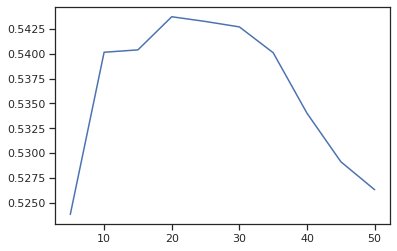

In [35]:
# Изменение качества на тестовой выборке в зависимости от К-соседей
plt.plot(n_range, grid_search.cv_results_['mean_test_score'])

In [36]:
# Обучение лучшей модели
grid_search.best_estimator_.fit(wines_X_train, wines_y_train)
tuned_target_train = grid_search.best_estimator_.predict(wines_X_train)
tuned_target_test = grid_search.best_estimator_.predict(wines_X_test)

In [37]:
# Новое качество модели, коэффициент детерминации
r2_score(wines_y_train, tuned_target_train), r2_score(wines_y_test, tuned_target_test)

(0.6013464411712885, 0.492594929478846)

In [38]:
# Качество модели до подбора гиперпараметров, коэффициент детерминации
r2_score(wines_y_train, target_train), r2_score(wines_y_test, target_test)

(0.703085341805602, 0.48368524104442)

Как видно из оценки качества регрессии разница между показателями для тестовой и обучающей выборки сократилась, но все равно показатель на обучающей выборке на 0.1 выше, то есть имеет место переобучение. Также показатель 0.5 свидетельствует о среднем качестве модели вцелом. 

In [39]:
# функция для построения кривых обучения
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5),scoring=None):
    """
    Generate a simple plot of the test and training learning curve.

    Parameters
    ----------
    estimator : object type that implements the "fit" and "predict" methods
        An object of that type which is cloned for each validation.

    title : string
        Title for the chart.

    X : array-like, shape (n_samples, n_features)
        Training vector, where n_samples is the number of samples and
        n_features is the number of features.

    y : array-like, shape (n_samples) or (n_samples, n_features), optional
        Target relative to X for classification or regression;
        None for unsupervised learning.

    ylim : tuple, shape (ymin, ymax), optional
        Defines minimum and maximum yvalues plotted.

    cv : int, cross-validation generator or an iterable, optional
        Determines the cross-validation splitting strategy.
        Possible inputs for cv are:
          - None, to use the default 3-fold cross-validation,
          - integer, to specify the number of folds.
          - :term:`CV splitter`,
          - An iterable yielding (train, test) splits as arrays of indices.

        For integer/None inputs, if ``y`` is binary or multiclass,
        :class:`StratifiedKFold` used. If the estimator is not a classifier
        or if ``y`` is neither binary nor multiclass, :class:`KFold` is used.

        Refer :ref:`User Guide <cross_validation>` for the various
        cross-validators that can be used here.

    n_jobs : int or None, optional (default=None)
        Number of jobs to run in parallel.
        ``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.
        ``-1`` means using all processors. See :term:`Glossary <n_jobs>`
        for more details.

    train_sizes : array-like, shape (n_ticks,), dtype float or int
        Relative or absolute numbers of training examples that will be used to
        generate the learning curve. If the dtype is float, it is regarded as a
        fraction of the maximum size of the training set (that is determined
        by the selected validation method), i.e. it has to be within (0, 1].
        Otherwise it is interpreted as absolute sizes of the training sets.
        Note that for classification the number of samples usually have to
        be big enough to contain at least one sample from each class.
        (default: np.linspace(0.1, 1.0, 5))
    """
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes,scoring=scoring)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.3,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt

In [40]:
# импортируем кривые
from sklearn.model_selection import learning_curve, validation_curve

<module 'matplotlib.pyplot' from '/opt/conda/lib/python3.7/site-packages/matplotlib/pyplot.py'>

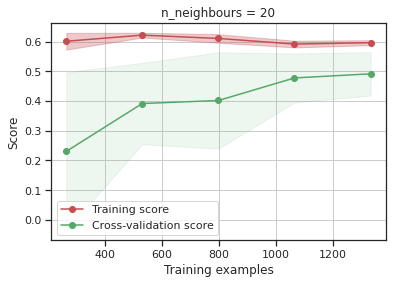

In [41]:
# Построение кривой обучения
# Оценка качества - коэффициент детерминации
# 6 фолдов для кросс-валидации
plot_learning_curve(grid_search.best_estimator_, "n_neighbours = "+str(grid_search.best_estimator_.n_neighbors), 
                    wines_regr_X, wines_regr_Y, cv=6, train_sizes=np.linspace(.2, 1.0, 5),scoring=scoring['r2'])

Как видно из графика кривой обучения требуется использовать значительную часть исходной выборки в качестве обучающей, чтобы получить приемлимую разницу между оценками качества.

In [42]:
# функция для построения кривой валидации
def plot_validation_curve(estimator, title, X, y, 
                          param_name, param_range, cv, 
                          scoring="accuracy"):
                                                   
    train_scores, test_scores = validation_curve(
        estimator, X, y, param_name=param_name, param_range=param_range,
        cv=cv, scoring=scoring, n_jobs=1)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    plt.title(title)
    plt.xlabel(param_name)
    plt.ylabel(str(scoring))
    plt.ylim(0.0, 1.1)
    lw = 2
    plt.plot(param_range, train_scores_mean, label="Training score",
                 color="darkorange", lw=lw)
    plt.fill_between(param_range, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.4,
                     color="darkorange", lw=lw)
    plt.plot(param_range, test_scores_mean, label="Cross-validation score",
                 color="navy", lw=lw)
    plt.fill_between(param_range, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.2,
                     color="navy", lw=lw)
    plt.legend(loc="best")
    return plt

<module 'matplotlib.pyplot' from '/opt/conda/lib/python3.7/site-packages/matplotlib/pyplot.py'>

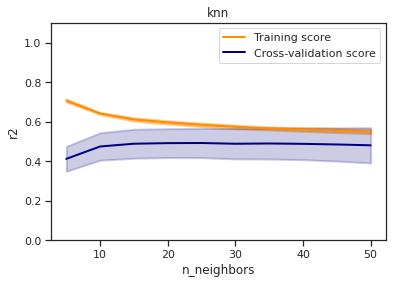

In [43]:
# Построение кривой валидации
# Оценка качества - коэффициент детерминации
# 6 фолдов для кросс-валидации
plot_validation_curve(grid_search.best_estimator_, 'knn', 
                      wines_regr_X, wines_regr_Y, 
                      param_name='n_neighbors', param_range=tuned_parameters[0]['n_neighbors'], 
                      cv = 6, scoring=scoring['r2'])

Как видно из кривой валидации, количество соседей = 20 представляет некоторую среднюю точку. При меньших значениях вырастает показатель качества на тренировочной выборке, при этом увеличивается разница между ним и показателем для кросс-валидации. При количестве соседей > 20 разница уменьшается, но оба показателя становятся меньше.

Таким образом, для выбранного целевого признака была решена задачи регрессии. Качество полученной модели среднее, наблюдается переобучение. Благодаря подбору гиперпараметров качество незначительно выросло, но заметно уменьшилось переобучение.

# 4. Решение задачи классификации
Для задачи классификации был выбран целевой признак *quality*, который является категориальным и имеет неравномерное распределение по группам.

In [44]:
# Статистические характеристики целевого признака
wines['quality'].describe()

count    1599.000000
mean        5.636023
std         0.807569
min         3.000000
25%         5.000000
50%         6.000000
75%         6.000000
max         8.000000
Name: quality, dtype: float64

In [45]:
# Уникальные значения признака и их количество
wines['quality'].value_counts()

5    681
6    638
7    199
4     53
8     18
3     10
Name: quality, dtype: int64

# 4.1 Разделение переменных и выборки

In [46]:
# Выделяем входные признаки
wines_X = wines.iloc[:, :-1].values
wines_X

array([[ 7.4  ,  0.7  ,  0.   , ...,  3.51 ,  0.56 ,  9.4  ],
       [ 7.8  ,  0.88 ,  0.   , ...,  3.2  ,  0.68 ,  9.8  ],
       [ 7.8  ,  0.76 ,  0.04 , ...,  3.26 ,  0.65 ,  9.8  ],
       ...,
       [ 6.3  ,  0.51 ,  0.13 , ...,  3.42 ,  0.75 , 11.   ],
       [ 5.9  ,  0.645,  0.12 , ...,  3.57 ,  0.71 , 10.2  ],
       [ 6.   ,  0.31 ,  0.47 , ...,  3.39 ,  0.66 , 11.   ]])

In [47]:
# Выделяем целевой признак
wines_Y = wines.iloc[:, -1].values
wines_Y

array([5, 5, 5, ..., 6, 5, 6])

Для того, чтобы использовать бинарные метрики, преобразуем **целевой признак в бинарный**:
Вино хорошее, если качество > 5 (1), иначе вино плохое (0).

In [48]:
# Преобразуем целевой признак в бинарный
wines_Y=(wines_Y>5).astype(int)
wines_Y

array([0, 0, 0, ..., 1, 0, 1])

In [49]:
# Разделение выборки на обучающую и тестовую
wines_X_train, wines_X_test, wines_y_train, wines_y_test = train_test_split(
    wines_X, wines_Y, test_size=0.3, random_state=42)

# 4.2 Обучение модели и оценка качества

In [50]:
# Строим модель 5 ближайших соседей
knn_5 = KNeighborsClassifier(n_neighbors=5)
knn_5.fit(wines_X_train, wines_y_train)
target_train = knn_5.predict(wines_X_train)
target_test = knn_5.predict(wines_X_test)

In [51]:
# Функция вывода метрики Accuracy для каждого класса признака
from typing import Dict
def accuracy_score_for_classes(
    y_true: np.ndarray, 
    y_pred: np.ndarray) -> Dict[int, float]:
    """
    Вычисление метрики accuracy для каждого класса
    y_true - истинные значения классов
    y_pred - предсказанные значения классов
    Возвращает словарь: ключ - метка класса, 
    значение - Accuracy для данного класса
    """
    # Для удобства фильтрации сформируем Pandas DataFrame 
    d = {'t': y_true, 'p': y_pred}
    df = pd.DataFrame(data=d)
    # Метки классов
    classes = np.unique(y_true)
    # Результирующий словарь
    res = dict()
    # Перебор меток классов
    for c in classes:
        # отфильтруем данные, которые соответствуют 
        # текущей метке класса в истинных значениях
        temp_data_flt = df[df['t']==c]
        # расчет accuracy для заданной метки класса
        temp_acc = accuracy_score(
            temp_data_flt['t'].values, 
            temp_data_flt['p'].values)
        # сохранение результата в словарь
        res[c] = temp_acc
    return res

def print_accuracy_score_for_classes(
    y_true: np.ndarray, 
    y_pred: np.ndarray):
    """
    Вывод метрики accuracy для каждого класса
    """
    accs = accuracy_score_for_classes(y_true, y_pred)
    if len(accs)>0:
        print('Метка \t Accuracy')
    for i in accs:
        print('{} \t {}'.format(i, accs[i]))

In [52]:
# Вывод метрики Accuracy для каждого класса целевого признака
print_accuracy_score_for_classes(wines_y_test, target_test)

Метка 	 Accuracy
0 	 0.5774647887323944
1 	 0.6666666666666666


In [53]:
# Accuracy для обучающей и тестовой выборок
accuracy_score(wines_y_train, target_train), accuracy_score(wines_y_test, target_test)

(0.7712243074173369, 0.6270833333333333)

In [54]:
# Импорт функции для вывод основных оценок качества
from sklearn.metrics import classification_report

In [55]:
# Вывод отчета по метрикам классификации
classification_report(wines_y_test, target_test, 
                       target_names=["bad wine","good wine"],output_dict=True)

{'bad wine': {'precision': 0.5801886792452831,
  'recall': 0.5774647887323944,
  'f1-score': 0.5788235294117647,
  'support': 213},
 'good wine': {'precision': 0.664179104477612,
  'recall': 0.6666666666666666,
  'f1-score': 0.6654205607476634,
  'support': 267},
 'accuracy': 0.6270833333333333,
 'macro avg': {'precision': 0.6221838918614475,
  'recall': 0.6220657276995305,
  'f1-score': 0.622122045079714,
  'support': 480},
 'weighted avg': {'precision': 0.6269083532807661,
  'recall': 0.6270833333333333,
  'f1-score': 0.6269931280923584,
  'support': 480}}

Как видно из представленных метрик, модель обладает приемлимым качеством, наблюдается небольшое переобучение, оценки по классу *хорошее вино* несколько выше, чем для класса *плохое вино*.

In [56]:
# Словарь метрик качества классификации 
scoring = {'precision': 'precision_weighted', 
           'recall': 'recall_weighted',
           'f1': 'f1_weighted'}

# 4.3 Построение модели и кросс-валидация

In [57]:
# Проводим кросс-валидацию для 5nn
scores = cross_validate(KNeighborsClassifier(n_neighbors=5), 
                        wines_X, wines_Y, scoring=scoring, 
                        cv=5, return_train_score=True)
scores

{'fit_time': array([0.00190496, 0.00161719, 0.00156856, 0.00145626, 0.00153875]),
 'score_time': array([0.01815939, 0.01679873, 0.01697946, 0.01750898, 0.01687765]),
 'test_precision': array([0.66105116, 0.60155351, 0.61546345, 0.54154627, 0.5521097 ]),
 'train_precision': array([0.77548398, 0.76888762, 0.75490694, 0.78402658, 0.775     ]),
 'test_recall': array([0.640625  , 0.603125  , 0.615625  , 0.546875  , 0.55485893]),
 'train_recall': array([0.77482408, 0.76856919, 0.7544957 , 0.78342455, 0.775     ]),
 'test_f1': array([0.63647599, 0.60134019, 0.61553822, 0.53595085, 0.5520879 ]),
 'train_f1': array([0.77500054, 0.76868139, 0.75463488, 0.78358712, 0.775     ])}

Как видим из результатов кросс-валидации, F1-мера **выше на обучающей выборке**, чем на тестовой. Проверим, возможно ли улучшить показатели, проведя подбор гиперпараметров.

# 4.4 Grid Search и кросс-валидация

In [58]:
%%time
# Производим подбор гиперпараметра, используя для оценки качества F1-меру
# и 5 фолдов для кросс-валидации
grid_search = GridSearchCV(KNeighborsClassifier(), tuned_parameters, cv=5, scoring=scoring["f1"])
grid_search.fit(wines_X_train, wines_y_train)

CPU times: user 679 ms, sys: 3.63 ms, total: 682 ms
Wall time: 679 ms


GridSearchCV(cv=5, error_score=nan,
             estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30,
                                            metric='minkowski',
                                            metric_params=None, n_jobs=None,
                                            n_neighbors=5, p=2,
                                            weights='uniform'),
             iid='deprecated', n_jobs=None,
             param_grid=[{'n_neighbors': array([ 5, 10, 15, 20, 25, 30, 35, 40, 45, 50])}],
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='f1_weighted', verbose=0)

In [59]:
# Выводим результаты подбора
grid_search.cv_results_

{'mean_fit_time': array([0.00114136, 0.00106144, 0.00107493, 0.00111647, 0.00105   ,
        0.0010891 , 0.00108919, 0.00108385, 0.00108752, 0.00110145]),
 'std_fit_time': array([1.13081346e-04, 5.71648009e-05, 4.07796423e-05, 2.86119778e-05,
        2.93101682e-05, 4.02813111e-05, 4.53701473e-05, 3.09757029e-05,
        4.09337969e-05, 3.31939631e-05]),
 'mean_score_time': array([0.01164165, 0.01117439, 0.01145759, 0.01171665, 0.01177049,
        0.01187286, 0.01224384, 0.01244683, 0.01254764, 0.0126287 ]),
 'std_score_time': array([0.00096087, 0.00010175, 0.00026222, 0.00014599, 0.00016843,
        0.00025447, 0.00010232, 0.00013199, 0.00028415, 0.00027803]),
 'param_n_neighbors': masked_array(data=[5, 10, 15, 20, 25, 30, 35, 40, 45, 50],
              mask=[False, False, False, False, False, False, False, False,
                    False, False],
        fill_value='?',
             dtype=object),
 'params': [{'n_neighbors': 5},
  {'n_neighbors': 10},
  {'n_neighbors': 15},
  {'n_ne

In [60]:
# Лучшая модель
grid_search.best_estimator_

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=30, p=2,
                     weights='uniform')

In [61]:
# Лучшее значение метрики
grid_search.best_score_

0.6620302712693855

In [62]:
# Лучшее значение параметров
grid_search.best_params_

{'n_neighbors': 30}

# 4.5 Оценка и анализ качества итоговой модели

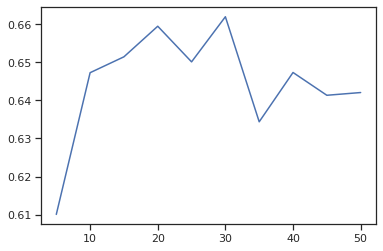

In [63]:
# Изменение качества на тестовой выборке в зависимости от К-соседей
plt.plot(n_range, grid_search.cv_results_['mean_test_score'])

In [64]:
# Обучение лучшей модели
grid_search.best_estimator_.fit(wines_X_train, wines_y_train)
tuned_target_train = grid_search.best_estimator_.predict(wines_X_train)
tuned_target_test = grid_search.best_estimator_.predict(wines_X_test)

In [65]:
from sklearn.metrics import f1_score

In [66]:
# Новое качество модели, F1-мера
f1_score(wines_y_train, tuned_target_train), f1_score(wines_y_test, tuned_target_test)

(0.6989619377162629, 0.6692015209125475)

In [67]:
# Качество модели до подбора гиперпараметров, F1-мера
f1_score(wines_y_train, target_train), f1_score(wines_y_test, target_test)

(0.7758318739054292, 0.6654205607476634)

Как видно из оценки качества классификации разница между показателями для тестовой и обучающей выборки сократилась и составляет 0.03. Такого показателя удалось достичь за счет снижения качества на обучающей выборке.

<module 'matplotlib.pyplot' from '/opt/conda/lib/python3.7/site-packages/matplotlib/pyplot.py'>

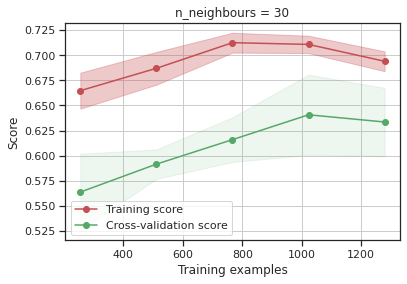

In [68]:
# Построение кривой обучения
# Оценка качества - F1-мера
# 5 фолдов для кросс-валидации
plot_learning_curve(grid_search.best_estimator_, "n_neighbours = "+str(grid_search.best_estimator_.n_neighbors), 
                    wines_X, wines_Y, cv=5, train_sizes=np.linspace(.2, 1.0, 5),scoring=scoring["f1"])

Как видно из кривой обучения наилучшее качество и соотношение между метриками достигается при размере обучающей выборке около 1000.

<module 'matplotlib.pyplot' from '/opt/conda/lib/python3.7/site-packages/matplotlib/pyplot.py'>

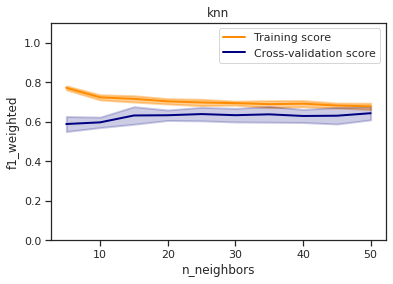

In [69]:
# Построение кривой валидации
# Оценка качества - F1-мера
# 5 фолдов для кросс-валидации
plot_validation_curve(grid_search.best_estimator_, 'knn', 
                      wines_X, wines_Y, 
                      param_name='n_neighbors', param_range=tuned_parameters[0]['n_neighbors'], 
                      cv = 5, scoring=scoring["f1"])

Как видно из кривой валидации, количество соседей = 30 представляет некоторую среднюю точку. При меньших значениях вырастает показатель качества на тренировочной выборке, при этом увеличивается разница между ним и показателем для кросс-валидации. При количестве соседей > 30 разница уменьшается, но показатель на тренировочной выборке становится меньше.

In [70]:
# Импорт ROC кривых
from sklearn.metrics import roc_curve, roc_auc_score

In [71]:
# Функция для отрисовки ROC-кривой
def draw_roc_curve(y_true, y_score, pos_label, average):
    fpr, tpr, thresholds = roc_curve(y_true, y_score, 
                                     pos_label=pos_label)
    roc_auc_value = roc_auc_score(y_true, y_score, average=average)
    plt.figure()
    lw = 2
    plt.plot(fpr, tpr, color='darkorange',
             lw=lw, label='ROC curve (area = %0.2f)' % roc_auc_value)
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example')
    plt.legend(loc="lower right")
    plt.show()


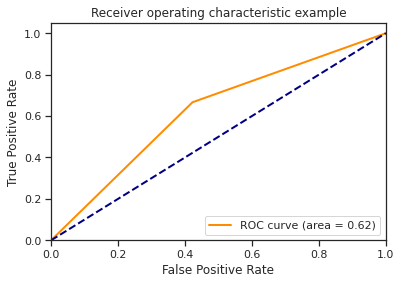

In [72]:
# ROC кривая до подбора гиперпараметров
draw_roc_curve(wines_y_test, target_test, pos_label=1, average='micro')

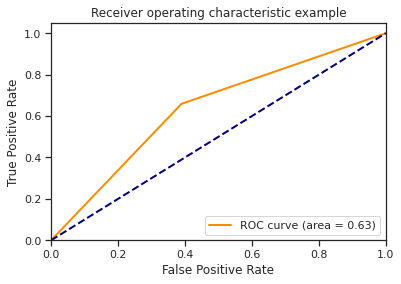

In [73]:
# ROC кривая после подбора гиперпараметров
draw_roc_curve(wines_y_test, tuned_target_test, pos_label=1, average='micro')

Исходя из графиков ROC-кривых, можно сделать вывод о том, что приращение области под кривой незначительное.

Таким образом, для выбранного целевого признака была решена задачи классификации. Качество полученной модели приемлимое, показатель качества несколько ниже 0.7. Благодаря подбору гиперпараметров качество на тренировочной выборке упало, но почти удалось устранить переобучение.

Итак, построенные модели не обладают высоким качеством, возможно это связано с плохой корреляцией признаков. Проверим это предположение.

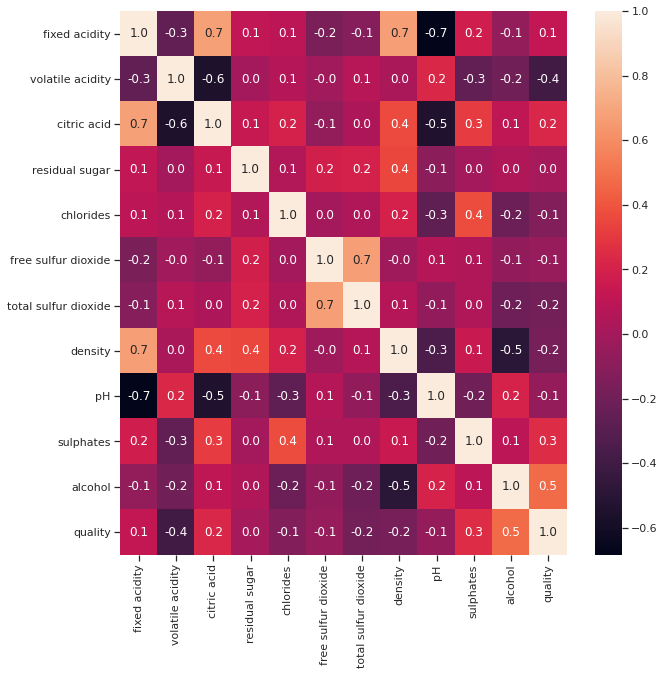

In [74]:
plt.figure(figsize=(10, 10))
sns.heatmap(wines.corr(),annot=True,fmt='.1f')

Как видно из матрицы корреляции, признаки, которые использовались в качестве целевых, слабо коррелируют с другими. Этим можно объяснить невысокое качество полученных моделей.

# 5. Выводы
В ходе лабораторной работы были изучены методы построения моделей регрессии и классификации с использованием кросс-валидации и подбора гиперпараметров, а также использованы различные метрики для оценки их качества.